<a id='Token_classification_with_Transformers'></a>
# Token classification with Transformers

## Importing libraries

In [57]:
!pip install evaluate
!pip install seqeval
# !pip install wandb

In [58]:
import os
import string
from typing import List
import warnings
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import nltk
import spacy
import re
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

%matplotlib inline

In [59]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/proccessed-geo-location-datasets
/kaggle/input/mantis-analytics-location-detection


In [60]:
# Check for CUDA availability for GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device {device}')

device cuda


In [61]:
from torch.nn import Transformer

# That's an example of a transformer architecture
Transformer()


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o

In [62]:
import pandas as pd

df_locations_ua = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/uk_geo_dataset.csv')
df_locations_ru = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/ru_geo_dataset.csv')

# uncomment for better perfomance
# we used this amount of data to the scores on kaggle LB
# df_locations_ru = df_locations_ru.sample(frac=0.01)
# df_locations_ua = df_locations_ua.sample(frac=0.1)

# uncomment following lines of code only for experimenting and presentation
df_locations_ru = df_locations_ru.sample(frac=0.001)
df_locations_ua = df_locations_ua.sample(frac=0.01)

## A bit of EDA

## Dataset Description
### **Name Entity Recognition dataset**

#### **uk_geo_dataset**

Ukrainian dataset Corpora Ukrainian. Approximately contains 1M text samples with location and organization entities.

Structure:

* text (str): text sample.

* loc_markers (List[tuple]): list of markers (spans) of location entities. Left and right indices.

* org_markers (List[tuple]): list of markers (spans) of origanization entities. Left and right indices.

* per_markers (List[tuple]): list of markers (spans) of person entities. Left and right indices.

* is_valid (int): whether it was taken from the validation split.

#### **ru_geo_dataset**

Russian dataset based on nerus dataset. Approximately contains 8M text samples with location and organization entities.

Structure:

* text (str): text sample.

* loc_markers (List[tuple]): list of markers (spans) of location entities. Left and right indices.

* org_markers (List[tuple]): list of markers (spans) of origanization entities. Left and right indices.

* per_markers (List[tuple]): list of markers (spans) of person entities. Left and right indices.

* doc_id (int): document id.

* sent_id (int): sentence id within a document.

#### **labeling_sample**

sample from the same distribution as test

Structure:

* text_id: id of text sample

* text: text sample

* locations: emply list that should be modified in your submission

* loc_markers: list of markers (spans) of location entities. Left and right indices.

#### **test**

Test dataset

Structure:

* text_id: id of text sample

* text: text sample

* locations: empty list that should be modified in your submission, you can check how to do this in this kernel

## Proposed Metric

Micro F1 Score = 2 * (precision * recall) / (precision + recall)

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Definitions:

* TP: locations that are both in predicted set and real set

* FP: locations that are in predicted set and NOT in real set

* FN: locations that are NOT in predicted set and in real set


In [63]:
# Display basic statistics of uk_geo_dataset
print(df_locations_ua.info())
print(df_locations_ua.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 10100 entries, 151822 to 874326
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10100 non-null  object
 1   loc_markers  10100 non-null  object
 2   org_markers  10100 non-null  object
 3   per_markers  10100 non-null  object
 4   is_valid     10100 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 473.4+ KB
None
           is_valid
count  10100.000000
mean       0.010099
std        0.099990
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [64]:
# Display basic statistics of ru_geo_dataset
print(df_locations_ru.info())
print(df_locations_ru.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8029 entries, 7767300 to 6958062
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8029 non-null   object
 1   loc_markers  8029 non-null   object
 2   org_markers  8029 non-null   object
 3   per_markers  8029 non-null   object
 4   doc_id       8029 non-null   int64 
 5   sent_id      8029 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 439.1+ KB
None
              doc_id      sent_id
count    8029.000000  8029.000000
mean   350090.419853     5.987047
std    204324.898115     8.841999
min        25.000000     0.000000
25%    178036.000000     2.000000
50%    337224.000000     5.000000
75%    517713.000000     9.000000
max    739144.000000   623.000000


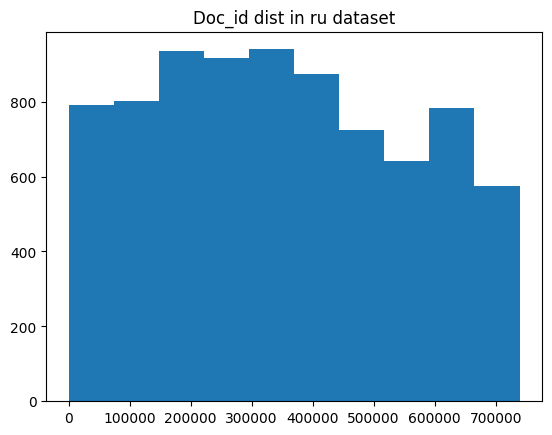

In [65]:
plt.title("Doc_id dist in ru dataset")
plt.hist(dict(df_locations_ru['doc_id'].value_counts()))
plt.show()

In [66]:
df_locations_ru['is_valid'] = 0  # Initialize 'is_valid' to 0 for all rows
df_locations_ru.loc[df_locations_ru['doc_id'] >= 700000, 'is_valid'] = 1

In [67]:
len(df_locations_ru[df_locations_ru['is_valid'] == 0]), len(df_locations_ru[df_locations_ru['is_valid'] == 1])

(7747, 282)

In [68]:
df_locations_ru.drop(['doc_id', 'sent_id'], axis=1,inplace=True)

In [69]:
df_locations_ru

,text,loc_markers,org_markers,per_markers,is_valid
7767300,Практически сразу подсудимые потребовали суда ...,[],[],[],1
7990253,Политические противники христианских демократо...,[],"[(158, 161)]","[(97, 103)]",1
4411483,"Об этом 21 марта сообщает агентство ""Интерфакс"".",[],"[(37, 46)]",[],0
3656969,"Концерт Мэнсона в ""Олимпийском"" станет частью ...",[],"[(19, 30)]","[(8, 15)]",0
1821590,Агафья Лыкова — единственная оставшаяся в живы...,[],[],"[(0, 13)]",0
...,...,...,...,...,...
5522979,В ближайшем будущем разработчики намерены доба...,"[(57, 63), (66, 73)]",[],[],0
3178098,Волокнистый вольфрам понадобился физикам для р...,[],[],[],0
695397,"Вариант ""мы час срем друг друга просто так, дл...",[],[],[],0
1335138,"Об этом в четверг, 15 сентября, рассказала пос...","[(49, 52), (56, 63)]","[(99, 117)]","[(64, 78)]",0


In [70]:
df_locations = pd.concat([df_locations_ru, df_locations_ua])

df_locations_copy = df_locations.copy()

df_locations.sample(10)

,text,loc_markers,org_markers,per_markers,is_valid
1074780,"25 января глава Чечни Рамзан Кадыров напомнил,...","[(16, 21)]",[],"[(22, 36)]",0
569182,"У ролях: Анна Міклош, Андрій Чернишов, Марія К...",[],[],"[(9, 20), (22, 37), (39, 52), (54, 75), (77, 9...",0
1008591,"Зазначимо, згідно з законом російський уряд за...","[(105, 107)]",[],[],1
1168479,«Аненербе» — немецкое общество по изучению дре...,"[(121, 129)]","[(1, 9)]",[],0
474472,Відносини Івана Баканова з главою Офісу Презид...,[],"[(34, 50)]","[(10, 24), (51, 67)]",0
3326651,«Консоли [Xbox 360 и PS3] задержались на рынке...,[],[],"[(83, 88)]",0
102073,Карантин у Києво-Печерській Лаврі запровадили ...,"[(11, 17), (17, 33)]",[],[],0
1631082,Предварительное голосование запланировано на 2...,[],[],[],0
3990702,Во Владикавказе полиция задержала 40 участнико...,"[(3, 15), (149, 161)]",[],"[(97, 110)]",0
384933,Про це зазначено на сторінці ЦНАП м. Львова у ...,[],"[(29, 43)]",[],0


In [71]:
df_locations.shape

(18129, 5)

In [72]:
# Check the class distribution in uk_geo_dataset
class_distribution = df_locations['is_valid'].value_counts()
print(class_distribution)

is_valid
0    17745
1      384
Name: count, dtype: int64


In [73]:
# Analyze text length
df_locations['text_length'] = df_locations['text'].apply(len)
print(df_locations['text_length'].describe())

# Analyze location markers
df_locations['num_loc_markers'] = df_locations['loc_markers'].apply(len)
print(df_locations['num_loc_markers'].describe())

count    18129.000000
mean       109.507033
std         52.571884
min          4.000000
25%         70.000000
50%         99.000000
75%        138.000000
max        872.000000
Name: text_length, dtype: float64
count    18129.000000
mean         5.704507
std          8.282003
min          2.000000
25%          2.000000
50%          2.000000
75%         10.000000
max        118.000000
Name: num_loc_markers, dtype: float64


In [74]:
# Let's explore example texts
sample_data = df_locations.sample(5)
for index, row in sample_data.iterrows():
    text = row['text']
    loc_markers = row['loc_markers']
    print(f"Text: {text}")
    print(f"Location Markers: {loc_markers}\n")

Text: Поэтому было решено назвать безымянную вершину именно в его честь», — рассказал Нищук.
Location Markers: []

Text: В 2012 году топ популярных событий возглавил запрос «выборы 2012».
Location Markers: []

Text: На защиту дома встали градозащитники.
Location Markers: []

Text: Позднее, в апреле 2009 года, ответственность за него взяла на себя "Настоящая ИРА" (Real IRA) - экстремистская группировка, отколовшаяся от Ирландской республиканской армии.
Location Markers: []

Text: Нападники підкинули невідомий залізний предмет під шини автомобілю співачки та після вимушеної зупинки намагались напасти на знімальну команду.
Location Markers: []



In [75]:
(df_locations["num_loc_markers"] == 0).value_counts()

num_loc_markers
False    18129
Name: count, dtype: int64

True here means that in the sentense there is no location mentioned;

False - that the location is mentioned.

num_loc_markers
2      13243
10      2258
12       596
20       480
22       236
       ...  
91         1
118        1
95         1
94         1
96         1
Name: count, Length: 75, dtype: int64

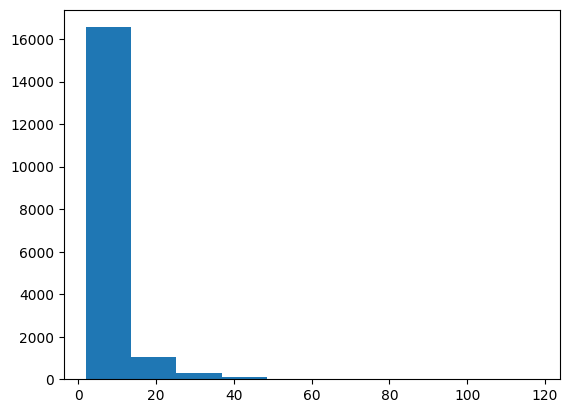

In [76]:
# Distribution of Number of locations
plt.hist(df_locations["num_loc_markers"])

df_locations["num_loc_markers"].value_counts()

<Axes: >

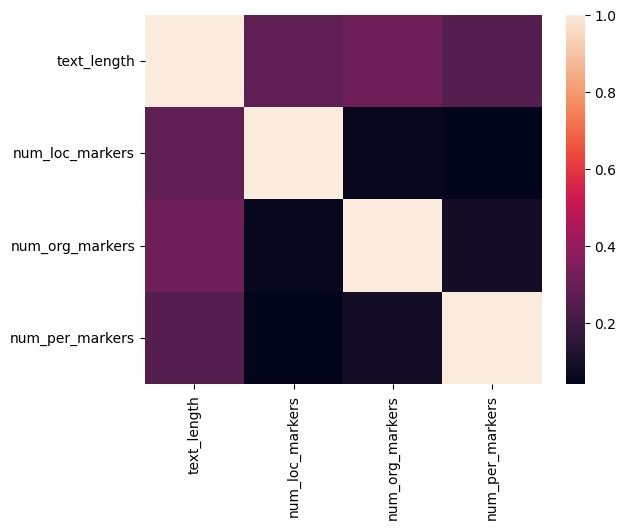

In [77]:
df_locations['num_org_markers'] = df_locations['org_markers'].apply(len)
df_locations['num_per_markers'] = df_locations['per_markers'].apply(len)

corr_ = df_locations[['text_length', 'num_loc_markers', 'num_org_markers', 'num_per_markers']]

sns.heatmap(corr_.corr())

We can see that number of loc_markers poorly corelates with other numeric features

## Text file in CoNLL format


In [78]:
df_locations = df_locations_copy.copy()
# just in case

df_locations

,text,loc_markers,org_markers,per_markers,is_valid
7767300,Практически сразу подсудимые потребовали суда ...,[],[],[],1
7990253,Политические противники христианских демократо...,[],"[(158, 161)]","[(97, 103)]",1
4411483,"Об этом 21 марта сообщает агентство ""Интерфакс"".",[],"[(37, 46)]",[],0
3656969,"Концерт Мэнсона в ""Олимпийском"" станет частью ...",[],"[(19, 30)]","[(8, 15)]",0
1821590,Агафья Лыкова — единственная оставшаяся в живы...,[],[],"[(0, 13)]",0
...,...,...,...,...,...
1000039,Розслідування справи розпочалося 2014 року і т...,[],[],[],1
83768,Тож на них ввели обмеження – не більше 3 упако...,[],[],[],0
875808,Кортні Кардашьян повністю оголилася для глянцю...,[],[],"[(7, 16)]",0
506197,У тому числі і власне російський національний ...,[],[],[],0


In [79]:
import spacy

from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

df_locations.loc_markers = df_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in eval(x)])

# Load a blank Spacy model for the "xx" language
nlp = spacy.blank("xx")

# Define a function to convert our data to CoNLL format
def convert_to_conll(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    
    # Create a Doc object from the input text without linguistic analysis
    doc = nlp.make_doc(data["text"])
    
    # Initialize an empty list to store the recognized entities
    ents = []
    
    # Iterate through the labeled entities in our data
    for start, end, label in data["label"]:
        # Check if the start and end positions are valid
        if start >= 0 and end <= len(data["text"]):
            # Create a Span for the recognized entity
            span = doc.char_span(start, end, label=label)
            if span is not None:
                ents.append(span)
    
    # Set the recognized entities in the Doc
    doc.ents = ents
    
    # Extract the text tokens from the Doc
    tokens = [t.text for t in doc]
    
    # Initialize a list to store IOB2 tags for the entities
    iob_tags = ['O'] * len(tokens)
    
    # Populate IOB2 tags for recognized entities
    for ent in ents:
        for token in doc:
            if token.idx == ent.start:
                iob_tags[token.i] = 'B-' + ent.label_
            elif ent.start < token.idx < ent.end:
                iob_tags[token.i] = 'I-' + ent.label_
    
    # Return a dictionary with tokens and corresponding IOB2 labels
    return {
        'tokens': tokens,
        'labels': iob_tags
    }

# Apply the 'convert_to_conll' function to our DataFrame 'df_locations' using 'progress_apply'
df_locations['conll'] = df_locations.progress_apply(convert_to_conll, axis=1)

  0%|          | 0/18129 [00:00<?, ?it/s]

In [80]:
label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}

df_locations['tokens'] = df_locations.conll.str['tokens']
df_locations['ner_tags'] = df_locations.conll.str['labels'].apply(lambda x: [label2id[t] for t in x])

df_train = df_locations[df_locations.is_valid == 0]
df_valid = df_locations[df_locations.is_valid == 1]

In [81]:
df_train[['tokens', 'ner_tags']].to_json(
    'train_processed.json', orient='records', lines=True)
df_valid[['tokens', 'ner_tags']].to_json(
    'valid_processed.json', orient='records', lines=True)

In [82]:
from datasets import load_dataset

raw_datasets_ua = load_dataset(
    "json",
    data_files={
        'train': 'train_processed.json',
        'val': 'valid_processed.json'
    }
)
raw_datasets_ua

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-623b66084ef048e9/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 17745
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 384
    })
})

We will use roberta-ua-base 

In [84]:
from transformers import AutoTokenizer, AutoModelForTokenClassification


id2label = {v: k for k, v in label2id.items()}

model = AutoModelForTokenClassification.from_pretrained(
    'xlm-roberta-base', # Best perfomance
#   'bert-base-multilingual-cased', # second best perfomance
#   'youscan/ukr-roberta-base',  # worst perfomance
    id2label=id2label,
    label2id=label2id,
)
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
from transformers import DataCollatorForTokenClassification

# Define a data collator for token classification using the provided tokenizer
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Define a function to align labels with tokens, taking care of special cases
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for i in range(len(word_ids)):
        word_id = word_ids[i]
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as the previous token
            label = labels[word_id]
            # If the label is B-XXX, change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

# Define a function to tokenize and align labels for token classification
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


In [86]:
raw_datasets_ua

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 17745
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 384
    })
})

In [87]:
# Tokenize and align labels for the Ukrainian raw datasets using the 'tokenize_and_align_labels' function.
# This is done in a batched manner, and the specified columns are removed from the resulting datasets.
tokenized_datasets_ua = raw_datasets_ua.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets_ua["train"].column_names,
)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [88]:
from transformers import TrainingArguments

# Define training arguments for a ROBERTA-based Ukrainian Named Entity Recognition (NER) model.
args = TrainingArguments(
    "roberta-ua-loc-ner",  # Specify the directory where model checkpoints and logs will be saved.
    per_device_train_batch_size=16,  # Batch size for training data on each device.
    per_device_eval_batch_size=16,  # Batch size for evaluation data on each device.
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch.
    save_strategy="epoch",  # Save model checkpoints at the end of each epoch.
    num_train_epochs=3  # Number of training epochs.
)


In [90]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW([
    {'params': list(model.roberta.parameters()), 'lr': 0.000006},
    {'params': list(model.classifier.parameters()), 'lr': 0.0012}
])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*3*(tokenized_datasets_ua['train'].num_rows/16),
    num_training_steps=3*(tokenized_datasets_ua['train'].num_rows/16)
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [91]:
import evaluate
import numpy as np

# Load a metric for sequence labeling (NER in this case) using the 'evaluate' module.
metric = evaluate.load("seqeval")

# Create a list of label names from the 'label2id' mapping.
label_names = list(label2id.keys())

# Define a function to compute evaluation metrics for NER predictions.
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert token IDs to label names
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Use the loaded metric to compute precision, recall, F1, and accuracy
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [92]:
df_locations

,text,loc_markers,org_markers,per_markers,is_valid,conll,tokens,ner_tags
7767300,Практически сразу подсудимые потребовали суда ...,[],[],[],1,"{'tokens': ['Практически', 'сразу', 'подсудимы...","[Практически, сразу, подсудимые, потребовали, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7990253,Политические противники христианских демократо...,[],"[(158, 161)]","[(97, 103)]",1,"{'tokens': ['Политические', 'противники', 'хри...","[Политические, противники, христианских, демок...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4411483,"Об этом 21 марта сообщает агентство ""Интерфакс"".",[],"[(37, 46)]",[],0,"{'tokens': ['Об', 'этом', '21', 'марта', 'сооб...","[Об, этом, 21, марта, сообщает, агентство, "", ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3656969,"Концерт Мэнсона в ""Олимпийском"" станет частью ...",[],"[(19, 30)]","[(8, 15)]",0,"{'tokens': ['Концерт', 'Мэнсона', 'в', '""', 'О...","[Концерт, Мэнсона, в, "", Олимпийском, "", стане...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1821590,Агафья Лыкова — единственная оставшаяся в живы...,[],[],"[(0, 13)]",0,"{'tokens': ['Агафья', 'Лыкова', '—', 'единстве...","[Агафья, Лыкова, —, единственная, оставшаяся, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
1000039,Розслідування справи розпочалося 2014 року і т...,[],[],[],1,"{'tokens': ['Розслідування', 'справи', 'розпоч...","[Розслідування, справи, розпочалося, 2014, рок...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
83768,Тож на них ввели обмеження – не більше 3 упако...,[],[],[],0,"{'tokens': ['Тож', 'на', 'них', 'ввели', 'обме...","[Тож, на, них, ввели, обмеження, –, не, більше...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
875808,Кортні Кардашьян повністю оголилася для глянцю...,[],[],"[(7, 16)]",0,"{'tokens': ['Кортні', 'Кардашьян', 'повністю',...","[Кортні, Кардашьян, повністю, оголилася, для, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
506197,У тому числі і власне російський національний ...,[],[],[],0,"{'tokens': ['У', 'тому', 'числі', 'і', 'власне...","[У, тому, числі, і, власне, російський, націон...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [93]:

def count_locations(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    doc = nlp.make_doc(data["text"])  # Create a Doc without linguistic analysis
    ents = []
    for start, end, label in data["label"]:
        # Check if the start and end positions are valid
        if start >= 0 and end <= len(data["text"]):
            span = doc.char_span(start, end, label=label)
            if span is not None:
                ents.append(span)
    doc.ents = ents
    
    # Count the number of location entities
    num_locations = len([ent for ent in ents if ent.label_ == 'LOC'])

    return num_locations

# Create a new column 'num_locations' with the count of locations
df_locations['num_locations'] = df_locations.progress_apply(count_locations, axis=1)

  0%|          | 0/18129 [00:00<?, ?it/s]

In [94]:
df_locations["stratify_col"] = df_locations["num_locations"]
df_locations.loc[df_locations["num_locations"] >= 14, "stratify_col"] = -1

In [95]:
df_locations.head()

,text,loc_markers,org_markers,per_markers,is_valid,conll,tokens,ner_tags,num_locations,stratify_col
7767300,Практически сразу подсудимые потребовали суда ...,[],[],[],1,"{'tokens': ['Практически', 'сразу', 'подсудимы...","[Практически, сразу, подсудимые, потребовали, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
7990253,Политические противники христианских демократо...,[],"[(158, 161)]","[(97, 103)]",1,"{'tokens': ['Политические', 'противники', 'хри...","[Политические, противники, христианских, демок...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
4411483,"Об этом 21 марта сообщает агентство ""Интерфакс"".",[],"[(37, 46)]",[],0,"{'tokens': ['Об', 'этом', '21', 'марта', 'сооб...","[Об, этом, 21, марта, сообщает, агентство, "", ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
3656969,"Концерт Мэнсона в ""Олимпийском"" станет частью ...",[],"[(19, 30)]","[(8, 15)]",0,"{'tokens': ['Концерт', 'Мэнсона', 'в', '""', 'О...","[Концерт, Мэнсона, в, "", Олимпийском, "", стане...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
1821590,Агафья Лыкова — единственная оставшаяся в живы...,[],[],"[(0, 13)]",0,"{'tokens': ['Агафья', 'Лыкова', '—', 'единстве...","[Агафья, Лыкова, —, единственная, оставшаяся, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0


In [96]:
n_splits = 4  # Number of cross-validation folds
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [97]:
# my_api_key = whatever your wandb api key is

In [98]:
from transformers import Trainer
import wandb
# for fold, (train_idx, valid_idx) in enumerate(stratified_kfold.split(df_locations, df_locations['stratify_col'])):
#     # Split the dataset into training and validation sets for the current fold
#     train_data = df_locations.iloc[train_idx]
#     valid_data = df_locations.iloc[valid_idx]

#     # Tokenize and preprocess the data for this fold (similar to what you did for a single split)
#     tokenized_train_data = train_data.progress_apply(tokenize_and_align_labels, axis=1)
#     tokenized_valid_data = valid_data.progress_apply(tokenize_and_align_labels, axis=1)

#     # Create and train the model for this fold
#     trainer = Trainer(
#         model=model,
#         args=args,
#         train_dataset=tokenized_train_data,
#         eval_dataset=tokenized_valid_data,
#         data_collator=data_collator,
#         compute_metrics=compute_metrics,
#         tokenizer=tokenizer,
#         optimizers=(optimizer, scheduler)
#     )
#     trainer.train()

# wandb.login(key=my_api_key)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_ua["train"],
    eval_dataset=tokenized_datasets_ua["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler)
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.021400,0.019353,0.000000,0.000000,0.000000,0.996165
2,0.016000,0.015027,1.000000,0.034483,0.066667,0.996245
3,0.014700,0.015140,0.285714,0.068966,0.111111,0.995846


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=3330, training_loss=0.03224380710819462, metrics={'train_runtime': 654.4129, 'train_samples_per_second': 81.348, 'train_steps_per_second': 5.089, 'total_flos': 1714550915189520.0, 'train_loss': 0.03224380710819462, 'epoch': 3.0})

In [99]:
trainer.save_model("roberta-ua-loc-ner/cp1")

In [100]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "roberta-ua-loc-ner/cp1"

# Create a token classification pipeline using the specified model checkpoint.
# The 'aggregation_strategy' parameter is set to "simple" to handle multi-token entities.
token_classifier = pipeline(
    "token-classification",  # Task type for NER/token classification
    model=model_checkpoint,   # Load the model from the specified checkpoint
    aggregation_strategy="simple"  # Define how to handle multi-token entities
)

In [101]:
df_valid

,text,loc_markers,org_markers,per_markers,is_valid,conll,tokens,ner_tags
7767300,Практически сразу подсудимые потребовали суда ...,[],[],[],1,"{'tokens': ['Практически', 'сразу', 'подсудимы...","[Практически, сразу, подсудимые, потребовали, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7990253,Политические противники христианских демократо...,[],"[(158, 161)]","[(97, 103)]",1,"{'tokens': ['Политические', 'противники', 'хри...","[Политические, противники, христианских, демок...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7945668,Управлению ФСБ в Чечне удалось предотвратить т...,"[[17, 22, LOC], [78, 86, LOC]]","[(11, 14)]","[(87, 103)]",1,"{'tokens': ['Управлению', 'ФСБ', 'в', 'Чечне',...","[Управлению, ФСБ, в, Чечне, удалось, предотвра...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7725846,"По мнению следователей, Пассарис тесно связан ...","[[115, 122, LOC]]",[],"[(24, 32)]",1,"{'tokens': ['По', 'мнению', 'следователей', ',...","[По, мнению, следователей, ,, Пассарис, тесно,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7949059,"По словам Платонова, их не более 40, а наиболе...",[],[],"[(10, 19)]",1,"{'tokens': ['По', 'словам', 'Платонова', ',', ...","[По, словам, Платонова, ,, их, не, более, 40, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
1003457,"Мовляв, уже зрозуміло, що мільйон набереться ш...",[],[],[],1,"{'tokens': ['Мовляв', ',', 'уже', 'зрозуміло',...","[Мовляв, ,, уже, зрозуміло, ,, що, мільйон, на...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1009700,"Вона каже, що крім інфраструктури важливий і с...",[],[],[],1,"{'tokens': ['Вона', 'каже', ',', 'що', 'крім',...","[Вона, каже, ,, що, крім, інфраструктури, важл...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1005339,Оскільки головне джерело енергії для головного...,[],[],[],1,"{'tokens': ['Оскільки', 'головне', 'джерело', ...","[Оскільки, головне, джерело, енергії, для, гол...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1006833,Живий ланцюг — символ та головна традиція Дня ...,"[[138, 145, LOC], [148, 162, LOC]]",[],[],1,"{'tokens': ['Живий', 'ланцюг', '—', 'символ', ...","[Живий, ланцюг, —, символ, та, головна, традиц...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [102]:
predictions = []
test_data = pd.read_csv("/kaggle/input/proccessed-geo-location-datasets/test.csv")

for text_id, text in zip(test_data['text_id'], test_data['text']):
    prediction = token_classifier(text)
    location_entities = [entity['word'] for entity in prediction if entity['entity_group'] == 'LOC']
    predictions.append({'text_id': text_id, 'locations': location_entities})

result_df = pd.DataFrame(predictions)
result_df.to_csv("location_predictions.csv", index=False)


In [103]:
result_df

,text_id,locations
0,0,[]
1,1,[]
2,2,[]
3,3,[]
4,4,[]
...,...,...
472,472,[]
473,473,[]
474,474,[]
475,475,[]
